# Use engineered features to train a model
This code will use the features created to train a Light Gradient Boost Model (lgbm).
The process is:
1. Run a lgbm model and compare it to a base model

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import re
import datetime as dt
from rf_modules import *

In [2]:
#Import and combine prices files
path = r"C:\Users\Robert\Documents\python_scripts\stock_trading_ml_modelling\historical_prices"
df_ft = pd.read_hdf(path + r"\all_hist_prices_w_ft_eng2.h5")
print("SHAPE: {}".format(df_ft.shape))
print(df_ft.dtypes)
df_ft.head()

SHAPE: (281287, 144)
ticker                                    object
date                              datetime64[ns]
open                                     float64
close                                    float64
high                                     float64
                                       ...      
long_prev_min_move_date_volume           float64
long_max_grad_volume                     float64
long_min_grad_volume                     float64
long_grad_conv_volume                    float64
signal                                    object
Length: 144, dtype: object


,ticker,date,open,close,high,low,volume,change_price,per_change_price,ema26,...,prev_min_grad_volume,prev_grad_conv_volume,max_move_cum_volume,min_move_cum_volume,long_prev_max_move_date_volume,long_prev_min_move_date_volume,long_max_grad_volume,long_min_grad_volume,long_grad_conv_volume,signal
214063,SBRY,1995-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0.0,0.0,NaN,NaN,NaN,hold
214064,SBRY,1995-01-09,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,NaN,...,NaN,NaN,0,0,0.0,0.0,NaN,NaN,NaN,hold
214065,SBRY,1995-01-16,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,NaN,...,NaN,NaN,0,0,0.0,0.0,NaN,NaN,NaN,hold
214066,SBRY,1995-01-23,0.125278,1.000000,1.000000,0.599644,0.861339,0.874722,0.874722,NaN,...,NaN,NaN,0,0,0.0,0.0,NaN,NaN,NaN,sell
214067,SBRY,1995-01-30,1.000000,0.833416,0.861097,1.000000,0.546860,-0.166584,-0.199881,NaN,...,NaN,NaN,0,0,0.0,0.0,NaN,NaN,NaN,hold


In [3]:
df_ft.columns

Index(['ticker', 'date', 'open', 'close', 'high', 'low', 'volume',
       'change_price', 'per_change_price', 'ema26',
       ...
       'prev_min_grad_volume', 'prev_grad_conv_volume', 'max_move_cum_volume',
       'min_move_cum_volume', 'long_prev_max_move_date_volume',
       'long_prev_min_move_date_volume', 'long_max_grad_volume',
       'long_min_grad_volume', 'long_grad_conv_volume', 'signal'],
      dtype='object', length=144)

# Build the LGBM model
This model is designed to predict if a week should be buy, hold or sell.


In [4]:
#Import the feature cols
with open(path + r'\feature_engineering_feature_list.txt','r') as f:
    feature_cols = f.read().split(',')
for col in ['signal','ticker']:
    try:
        feature_cols.remove(col)
    except:
        print('{} DOES NOT EXIST'.format(col))
print('feature_cols length -> {}'.format(len(feature_cols)))
feature_cols

feature_cols length -> 141


['open',
 'close',
 'high',
 'low',
 'volume',
 'change_price',
 'per_change_price',
 'ema26',
 'macd',
 'signal_line',
 'macd_line',
 'close_orig_per_change_max_4',
 'close_orig_per_change_max_13',
 'close_orig_per_change_max_26',
 'close_orig_per_change_max_52',
 'close_orig_per_change_min_4',
 'close_orig_per_change_min_13',
 'close_orig_per_change_min_26',
 'close_orig_per_change_min_52',
 'macd_line_per_change_max_4',
 'macd_line_per_change_max_13',
 'macd_line_per_change_max_26',
 'macd_line_per_change_max_52',
 'macd_line_per_change_min_4',
 'macd_line_per_change_min_13',
 'macd_line_per_change_min_26',
 'macd_line_per_change_min_52',
 'change_close_shift1',
 'close_max',
 'close_min',
 'prev_max_close',
 'prev_min_close',
 'prev_max_close_date_change',
 'prev_min_close_date_change',
 'max_change_close',
 'min_change_close',
 'prev_max_grad_close',
 'prev_min_grad_close',
 'prev_grad_conv_close',
 'max_move_cum_close',
 'min_move_cum_close',
 'long_prev_max_move_date_close',
 'l

In [5]:
target_cols = 'signal'
df_model = df_ft[feature_cols+[target_cols]+['date']].copy()
print("COLUMNS:",df_model.columns)
print("COLUMNS:",df_model.dtypes)
print("SHAPE:",df_model.shape)

COLUMNS: Index(['open', 'close', 'high', 'low', 'volume', 'change_price',
       'per_change_price', 'ema26', 'macd', 'signal_line',
       ...
       'prev_grad_conv_volume', 'max_move_cum_volume', 'min_move_cum_volume',
       'long_prev_max_move_date_volume', 'long_prev_min_move_date_volume',
       'long_max_grad_volume', 'long_min_grad_volume', 'long_grad_conv_volume',
       'signal', 'date'],
      dtype='object', length=143)
COLUMNS: open                            float64
close                           float64
high                            float64
low                             float64
volume                          float64
                              ...      
long_max_grad_volume            float64
long_min_grad_volume            float64
long_grad_conv_volume           float64
signal                           object
date                     datetime64[ns]
Length: 143, dtype: object
SHAPE: (281287, 143)


In [6]:
#Remove rows with missing or infinate values
# df_model.dropna(inplace=True)
# df_model.reset_index(inplace=True)
# print("COLUMNS:",df_model.columns)
# print("SHAPE:",df_model.shape)

In [7]:
#Create the train and test dataset
#All prices pre-2014 are training, all post 2014 are testing
#This remove the posibility that we are learning from other shares at times what is good/bad
date_lim = dt.datetime(2014,1,1)

#Separate
df_train = df_model[df_model.date < date_lim]
df_valid = df_model[df_model.date >= date_lim]

#Reset the index and drop 'date' column
df_train = df_train.reset_index(drop=True).drop(columns=['date'])
df_valid = df_valid.reset_index(drop=True).drop(columns=['date'])

print("train rows: {:,}".format(df_train.shape[0]))
print("valid rows: {:,}".format(df_valid.shape[0]))

train rows: 186,993
valid rows: 94,294


In [8]:
#Shuffle the datasets
np.random.seed(0)
rand_index = np.random.permutation(df_train.index.values)
df_train = df_train.iloc[rand_index].reset_index(drop=True)
rand_index = np.random.permutation(df_valid.index.values)
df_valid = df_valid.iloc[rand_index].reset_index(drop=True)

In [9]:
#Function to calculate the True Positive Rate for each classifier
def calc_tpr(pred_signal_s,real_signal_s,features=[],unique_classes=['buy','sell','hold']):
    tpr_li = []
    for cl in unique_classes:
        tpr_li.append(measure_acc(pred_signal_s,real_signal_s,features,_opt_text=cl,_multiclass=True,_cl=cl))
    cols = [x for x in tpr_li[0]]
    tpr_df = pd.DataFrame(tpr_li,columns=cols)
    return tpr_df

# Separate into fetaures and targets 

In [10]:
#Train
X_train = df_train[feature_cols]
y_train = df_train[target_cols]
print('X_train.shape -> {}'.format(X_train.shape))
print('y_train.shape -> {}'.format(y_train.shape))
#Validation
X_valid = df_valid[feature_cols]
y_valid = df_valid[target_cols]
print('X_valid.shape -> {}'.format(X_valid.shape))
print('y_valid.shape -> {}'.format(y_valid.shape))

X_train.shape -> (186993, 141)
y_train.shape -> (186993,)
X_valid.shape -> (94294, 141)
y_valid.shape -> (94294,)


# Create a base level model
For "buy", "sell" and "hold" test what the accuracy is if all signals are positive.

In [11]:
#Buy model
unique_classes = y_valid.unique()
calc_tpr(np.full((1,y_valid.shape[0]),"buy")[0],y_valid,["ALL BUY"],unique_classes)

,feature,tot_p,tot_n,tpr,tnr,ppv,npv,acc,auc,opt_text
0,[ALL BUY],0,94294,0.0,1.0,0.00000,0.430738,0.430738,0.5,hold
1,[ALL BUY],94294,0,1.0,0.0,0.16491,0.000000,0.000000,0.5,buy
2,[ALL BUY],0,94294,0.0,1.0,0.00000,0.734172,0.734172,0.5,sell


In [12]:
#Sell model
calc_tpr(np.full((1,y_valid.shape[0]),"sell")[0],y_valid,["ALL SELL"],unique_classes)

,feature,tot_p,tot_n,tpr,tnr,ppv,npv,acc,auc,opt_text
0,[ALL SELL],0,94294,0.0,1.0,0.000000,0.430738,0.430738,0.5,hold
1,[ALL SELL],0,94294,0.0,1.0,0.000000,0.835090,0.835090,0.5,buy
2,[ALL SELL],94294,0,1.0,0.0,0.265828,0.000000,0.000000,0.5,sell


In [13]:
#Hold model
calc_tpr(np.full((1,y_valid.shape[0]),"hold")[0],y_valid,["ALL HOLD"],unique_classes)

,feature,tot_p,tot_n,tpr,tnr,ppv,npv,acc,auc,opt_text
0,[ALL HOLD],94294,0,1.0,0.0,0.569262,0.000000,0.000000,0.5,hold
1,[ALL HOLD],0,94294,0.0,1.0,0.000000,0.835090,0.835090,0.5,buy
2,[ALL HOLD],0,94294,0.0,1.0,0.000000,0.734172,0.734172,0.5,sell


# Creating a multi-classification model - LGBM
The model will take a one-vs-all approach (IE 1 if it is this value, 0 if it is anything else) using the variables of "buy", "hold", and "sell" individually and building a model to find the error rate on each one.

Error rate is determined by the four classifications:
- True positive - correct - model is 1, actual is 1
- True negative - correct - model is 0, actual is 0
- False positive - error - model is 1, actual is 0
- False negative - error - model is 0, actual is 1

In [14]:
#Import the modules
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [15]:
# #Build a custom loss function - DIDN'T GET WORKING
def lgbm_custom_loss(_y_act,_y_pred):
    #Convert _y_pred into classes
    _y_pred_conv = []
    _n_classes = len(np.unique(_y_act))
    for i in range(0,_y_act.shape[0]):
        _tmp_li = []
        for j in range(0,_n_classes):
            _tmp_li.append(_y_pred[(_y_act.shape[0]*j) + i])
        _y_pred_conv.append(np.argmax(_tmp_li))
    _y_pred_conv = np.array(_y_pred_conv)
    _ac_results = calc_tpr(_y_pred_conv,_y_act,unique_classes=range(0,_n_classes))
    _av = _ac_results[_ac_results.opt_text.isin([0,2])]['ppv'].mean() #Only average for buy and sell
    #If _av_ppv is 0 then append the time to prevent early stopping
    if _av == 0.5:
        _time_now = dt.datetime.now()
        _av += _time_now.hour*10**-4 + _time_now.minute*10**-6 + _time_now.second*10**-8
    # (eval_name, eval_result, is_higher_better)
    return 'lgbm_custom_loss',_av,True

In [16]:
#Create parameters grid
#Create fixed parameters
mod_fixed_params = {
    'boosting_type':'gbdt'
    ,'random_state':0
    ,'silent':False
    ,'objective':'multiclass'
    ,'num_class':np.unique(y_train)
    ,'min_samples_split':200 #Should be between 0.5-1% of samples
    ,'min_samples_leaf':50
    ,'n_estimators':20
    ,'subsample':0.8
}
print('mod_fixed_params -> {}'.format(mod_fixed_params))
search_params = {
    'fixed':{
        'cv':3
        ,'n_iter':80
#         'cv':2
#         ,'n_iter':1
        ,'verbose':True
        ,'random_state':0
    }
    ,'variable':{
        'learning_rate':[0.1,0.01,0.005]
        ,'num_leaves':np.linspace(10,1010,100,dtype=int)
        ,'max_depth':np.linspace(2,22,10,dtype=int)
    }
}
print('search_params -> {}'.format(search_params))
fit_params = {
    'verbose':True
    ,'eval_set':(X_valid,y_valid)
    ,'eval_metric':lgbm_custom_loss
#     ,'eval_metric':'auc'
    ,'early_stopping_rounds':5
}
print('fit_params -> {}'.format(fit_params))

mod_fixed_params -> {'boosting_type': 'gbdt', 'random_state': 0, 'silent': False, 'objective': 'multiclass', 'num_class': array(['buy', 'hold', 'sell'], dtype=object), 'min_samples_split': 200, 'min_samples_leaf': 50, 'n_estimators': 20, 'subsample': 0.8}
search_params -> {'fixed': {'cv': 3, 'n_iter': 80, 'verbose': True, 'random_state': 0}, 'variable': {'learning_rate': [0.1, 0.01, 0.005], 'num_leaves': array([  10,   20,   30,   40,   50,   60,   70,   80,   90,  100,  111,
        121,  131,  141,  151,  161,  171,  181,  191,  201,  212,  222,
        232,  242,  252,  262,  272,  282,  292,  302,  313,  323,  333,
        343,  353,  363,  373,  383,  393,  403,  414,  424,  434,  444,
        454,  464,  474,  484,  494,  504,  515,  525,  535,  545,  555,
        565,  575,  585,  595,  605,  616,  626,  636,  646,  656,  666,
        676,  686,  696,  706,  717,  727,  737,  747,  757,  767,  777,
        787,  797,  807,  818,  828,  838,  848,  858,  868,  878,  888,
        

In [17]:
run_time = process_time()
#Setup the model
lgb_mod = lgb.LGBMClassifier(**mod_fixed_params)
#Add the search grid
seed = np.random.seed(0)
gbm = RandomizedSearchCV(lgb_mod,search_params['variable'],**search_params['fixed'])
#Fit the model
gbm.fit(X_train,y_train,**fit_params)
print('Best parameters found by grid search are: {}'.format(gbm.best_params_))
run_time.end()

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[1]	valid_0's multi_logloss: 0.966891	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.960345	valid_0's lgbm_custom_loss: 0
[3]	valid_0's multi_logloss: 0.954547	valid_0's lgbm_custom_loss: 0
[4]	valid_0's multi_logloss: 0.949386	valid_0's lgbm_custom_loss: 0
[5]	valid_0's multi_logloss: 0.944791	valid_0's lgbm_custom_loss: 0
[6]	valid_0's multi_logloss: 0.940718	valid_0's lgbm_custom_loss: 0.501135
[7]	valid_0's multi_logloss: 0.937043	valid_0's lgbm_custom_loss: 0.45
[8]	valid_0's multi_logloss: 0.933614	valid_0's lgbm_custom_loss: 0.411111
[9]	valid_0's multi_logloss: 0.930574	valid_0's lgbm_custom_loss: 0.423295
[10]	valid_0's multi_logloss: 0.927884	valid_0's lgbm_custom_loss: 0.467253
[11]	valid_0's multi_logloss: 0.925385	valid_0's lgbm_custom_loss: 0.509368
[12]	valid_0's multi_logloss: 0.923147	valid_0's lgbm_custom_loss: 0.51182
[13]	valid_0's multi_logloss: 0.921171	valid_0's lgbm_custom_loss: 0.503221
[

[1]	valid_0's multi_logloss: 0.973944	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.97355	valid_0's lgbm_custom_loss: 0
[3]	valid_0's multi_logloss: 0.97315	valid_0's lgbm_custom_loss: 0
[4]	valid_0's multi_logloss: 0.972762	valid_0's lgbm_custom_loss: 0
[5]	valid_0's multi_logloss: 0.972372	valid_0's lgbm_custom_loss: 0
[6]	valid_0's multi_logloss: 0.971995	valid_0's lgbm_custom_loss: 0
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.973944	valid_0's lgbm_custom_loss: 0
[1]	valid_0's multi_logloss: 0.973951	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.973557	valid_0's lgbm_custom_loss: 0
[3]	valid_0's multi_logloss: 0.973172	valid_0's lgbm_custom_loss: 0
[4]	valid_0's multi_logloss: 0.972788	valid_0's lgbm_custom_loss: 0
[5]	valid_0's multi_logloss: 0.972417	valid_0's lgbm_custom_loss: 0
[6]	valid_0's multi_logloss: 0.

[1]	valid_0's multi_logloss: 0.973542	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.972751	valid_0's lgbm_custom_loss: 0
[3]	valid_0's multi_logloss: 0.971976	valid_0's lgbm_custom_loss: 0
[4]	valid_0's multi_logloss: 0.971202	valid_0's lgbm_custom_loss: 0
[5]	valid_0's multi_logloss: 0.970451	valid_0's lgbm_custom_loss: 0
[6]	valid_0's multi_logloss: 0.969696	valid_0's lgbm_custom_loss: 0
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.973542	valid_0's lgbm_custom_loss: 0
[1]	valid_0's multi_logloss: 0.973546	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.972764	valid_0's lgbm_custom_loss: 0
[3]	valid_0's multi_logloss: 0.971994	valid_0's lgbm_custom_loss: 0
[4]	valid_0's multi_logloss: 0.971245	valid_0's lgbm_custom_loss: 0
[5]	valid_0's multi_logloss: 0.970506	valid_0's lgbm_custom_loss: 0
[6]	valid_0's multi_logloss: 

[1]	valid_0's multi_logloss: 0.966996	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.960497	valid_0's lgbm_custom_loss: 0
[3]	valid_0's multi_logloss: 0.954699	valid_0's lgbm_custom_loss: 0
[4]	valid_0's multi_logloss: 0.949475	valid_0's lgbm_custom_loss: 0
[5]	valid_0's multi_logloss: 0.944888	valid_0's lgbm_custom_loss: 0
[6]	valid_0's multi_logloss: 0.940661	valid_0's lgbm_custom_loss: 0.25
[7]	valid_0's multi_logloss: 0.93692	valid_0's lgbm_custom_loss: 0.166667
[8]	valid_0's multi_logloss: 0.933453	valid_0's lgbm_custom_loss: 0.142857
[9]	valid_0's multi_logloss: 0.93036	valid_0's lgbm_custom_loss: 0.2
[10]	valid_0's multi_logloss: 0.927563	valid_0's lgbm_custom_loss: 0.501152
[11]	valid_0's multi_logloss: 0.925041	valid_0's lgbm_custom_loss: 0.541667
[12]	valid_0's multi_logloss: 0.922712	valid_0's lgbm_custom_loss: 0.545507
[13]	valid_0's multi_logloss: 0.920534	valid_0's lgbm_custom_loss: 0.587737
[14]	va

[2]	valid_0's multi_logloss: 0.973585	valid_0's lgbm_custom_loss: 0
[3]	valid_0's multi_logloss: 0.973203	valid_0's lgbm_custom_loss: 0
[4]	valid_0's multi_logloss: 0.972824	valid_0's lgbm_custom_loss: 0
[5]	valid_0's multi_logloss: 0.972448	valid_0's lgbm_custom_loss: 0
[6]	valid_0's multi_logloss: 0.972076	valid_0's lgbm_custom_loss: 0
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.973969	valid_0's lgbm_custom_loss: 0
[1]	valid_0's multi_logloss: 0.97361	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.972875	valid_0's lgbm_custom_loss: 0
[3]	valid_0's multi_logloss: 0.972149	valid_0's lgbm_custom_loss: 0
[4]	valid_0's multi_logloss: 0.971431	valid_0's lgbm_custom_loss: 0
[5]	valid_0's multi_logloss: 0.970725	valid_0's lgbm_custom_loss: 0
[6]	valid_0's multi_logloss: 0.970023	valid_0's lgbm_custom_loss: 0
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.97361	valid_0's lgbm_cus

[10]	valid_0's multi_logloss: 0.928372	valid_0's lgbm_custom_loss: 0.511638
[11]	valid_0's multi_logloss: 0.926062	valid_0's lgbm_custom_loss: 0.511665
Early stopping, best iteration is:
[6]	valid_0's multi_logloss: 0.940852	valid_0's lgbm_custom_loss: 0.833333
[1]	valid_0's multi_logloss: 0.973949	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.97355	valid_0's lgbm_custom_loss: 0
[3]	valid_0's multi_logloss: 0.973152	valid_0's lgbm_custom_loss: 0
[4]	valid_0's multi_logloss: 0.972761	valid_0's lgbm_custom_loss: 0
[5]	valid_0's multi_logloss: 0.972377	valid_0's lgbm_custom_loss: 0
[6]	valid_0's multi_logloss: 0.971994	valid_0's lgbm_custom_loss: 0
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.973949	valid_0's lgbm_custom_loss: 0
[1]	valid_0's multi_logloss: 0.973937	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.973527	va

[6]	valid_0's multi_logloss: 0.969949	valid_0's lgbm_custom_loss: 0
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.973598	valid_0's lgbm_custom_loss: 0
[1]	valid_0's multi_logloss: 0.973607	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.972868	valid_0's lgbm_custom_loss: 0
[3]	valid_0's multi_logloss: 0.972138	valid_0's lgbm_custom_loss: 0
[4]	valid_0's multi_logloss: 0.971417	valid_0's lgbm_custom_loss: 0
[5]	valid_0's multi_logloss: 0.970708	valid_0's lgbm_custom_loss: 0
[6]	valid_0's multi_logloss: 0.970007	valid_0's lgbm_custom_loss: 0
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.973607	valid_0's lgbm_custom_loss: 0
[1]	valid_0's multi_logloss: 0.973656	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.972967	valid_0's lgbm_custom_loss: 0
[3]	valid_0's multi_logloss: 0.972285	valid_0's lgbm_custom_lo

[4]	valid_0's multi_logloss: 0.971383	valid_0's lgbm_custom_loss: 0
[5]	valid_0's multi_logloss: 0.970664	valid_0's lgbm_custom_loss: 0
[6]	valid_0's multi_logloss: 0.969949	valid_0's lgbm_custom_loss: 0
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.973598	valid_0's lgbm_custom_loss: 0
[1]	valid_0's multi_logloss: 0.973607	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.972868	valid_0's lgbm_custom_loss: 0
[3]	valid_0's multi_logloss: 0.972138	valid_0's lgbm_custom_loss: 0
[4]	valid_0's multi_logloss: 0.971417	valid_0's lgbm_custom_loss: 0
[5]	valid_0's multi_logloss: 0.970708	valid_0's lgbm_custom_loss: 0
[6]	valid_0's multi_logloss: 0.970007	valid_0's lgbm_custom_loss: 0
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.973607	valid_0's lgbm_custom_loss: 0
[1]	valid_0's multi_logloss: 0.966905	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 r

[1]	valid_0's multi_logloss: 0.97355	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.972783	valid_0's lgbm_custom_loss: 0
[3]	valid_0's multi_logloss: 0.972024	valid_0's lgbm_custom_loss: 0
[4]	valid_0's multi_logloss: 0.97127	valid_0's lgbm_custom_loss: 0
[5]	valid_0's multi_logloss: 0.970542	valid_0's lgbm_custom_loss: 0
[6]	valid_0's multi_logloss: 0.969819	valid_0's lgbm_custom_loss: 0
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.97355	valid_0's lgbm_custom_loss: 0
[1]	valid_0's multi_logloss: 0.973511	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.972698	valid_0's lgbm_custom_loss: 0
[3]	valid_0's multi_logloss: 0.97191	valid_0's lgbm_custom_loss: 0
[4]	valid_0's multi_logloss: 0.971135	valid_0's lgbm_custom_loss: 0
[5]	valid_0's multi_logloss: 0.970382	valid_0's lgbm_custom_loss: 0
[6]	valid_0's multi_logloss: 0.96

[11]	valid_0's multi_logloss: 0.927729	valid_0's lgbm_custom_loss: 0.494652
[12]	valid_0's multi_logloss: 0.925649	valid_0's lgbm_custom_loss: 0.486786
[13]	valid_0's multi_logloss: 0.924016	valid_0's lgbm_custom_loss: 0.475045
Early stopping, best iteration is:
[8]	valid_0's multi_logloss: 0.935178	valid_0's lgbm_custom_loss: 0.515664
[1]	valid_0's multi_logloss: 0.966724	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.960497	valid_0's lgbm_custom_loss: 0
[3]	valid_0's multi_logloss: 0.954863	valid_0's lgbm_custom_loss: 0
[4]	valid_0's multi_logloss: 0.949852	valid_0's lgbm_custom_loss: 0
[5]	valid_0's multi_logloss: 0.945504	valid_0's lgbm_custom_loss: 0.166667
[6]	valid_0's multi_logloss: 0.941844	valid_0's lgbm_custom_loss: 0.375
[7]	valid_0's multi_logloss: 0.938492	valid_0's lgbm_custom_loss: 0.557692
[8]	valid_0's multi_logloss: 0.935218	valid_0's lgbm_custom_loss: 0.480769
[9]	valid_0's multi_logloss: 0.93

[1]	valid_0's multi_logloss: 0.973578	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.972811	valid_0's lgbm_custom_loss: 0
[3]	valid_0's multi_logloss: 0.972053	valid_0's lgbm_custom_loss: 0
[4]	valid_0's multi_logloss: 0.971313	valid_0's lgbm_custom_loss: 0
[5]	valid_0's multi_logloss: 0.970576	valid_0's lgbm_custom_loss: 0
[6]	valid_0's multi_logloss: 0.969851	valid_0's lgbm_custom_loss: 0
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.973578	valid_0's lgbm_custom_loss: 0
[1]	valid_0's multi_logloss: 0.973553	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.972762	valid_0's lgbm_custom_loss: 0
[3]	valid_0's multi_logloss: 0.971986	valid_0's lgbm_custom_loss: 0
[4]	valid_0's multi_logloss: 0.971219	valid_0's lgbm_custom_loss: 0
[5]	valid_0's multi_logloss: 0.97047	valid_0's lgbm_custom_loss: 0
[6]	valid_0's multi_logloss: 0

[6]	valid_0's multi_logloss: 0.940484	valid_0's lgbm_custom_loss: 0
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.966893	valid_0's lgbm_custom_loss: 0
[1]	valid_0's multi_logloss: 0.966729	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.960038	valid_0's lgbm_custom_loss: 0
[3]	valid_0's multi_logloss: 0.95415	valid_0's lgbm_custom_loss: 0
[4]	valid_0's multi_logloss: 0.949025	valid_0's lgbm_custom_loss: 0
[5]	valid_0's multi_logloss: 0.944363	valid_0's lgbm_custom_loss: 0.501238
[6]	valid_0's multi_logloss: 0.940192	valid_0's lgbm_custom_loss: 0.2
[7]	valid_0's multi_logloss: 0.936436	valid_0's lgbm_custom_loss: 0.166667
[8]	valid_0's multi_logloss: 0.933021	valid_0's lgbm_custom_loss: 0.47619
[9]	valid_0's multi_logloss: 0.929933	valid_0's lgbm_custom_loss: 0.405594
[10]	valid_0's multi_logloss: 0.927173	valid_0's lgbm_custom_loss: 0.485714
Early stopping, best iteration is:
[5]	valid_0's mult

[1]	valid_0's multi_logloss: 0.973592	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.972841	valid_0's lgbm_custom_loss: 0
[3]	valid_0's multi_logloss: 0.972096	valid_0's lgbm_custom_loss: 0
[4]	valid_0's multi_logloss: 0.971361	valid_0's lgbm_custom_loss: 0
[5]	valid_0's multi_logloss: 0.970631	valid_0's lgbm_custom_loss: 0
[6]	valid_0's multi_logloss: 0.969916	valid_0's lgbm_custom_loss: 0
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.973592	valid_0's lgbm_custom_loss: 0
[1]	valid_0's multi_logloss: 0.973576	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.97281	valid_0's lgbm_custom_loss: 0
[3]	valid_0's multi_logloss: 0.972052	valid_0's lgbm_custom_loss: 0
[4]	valid_0's multi_logloss: 0.971303	valid_0's lgbm_custom_loss: 0
[5]	valid_0's multi_logloss: 0.970565	valid_0's lgbm_custom_loss: 0
[6]	valid_0's multi_logloss: 0

[6]	valid_0's multi_logloss: 0.969857	valid_0's lgbm_custom_loss: 0
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.973578	valid_0's lgbm_custom_loss: 0
[1]	valid_0's multi_logloss: 0.973592	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.972841	valid_0's lgbm_custom_loss: 0
[3]	valid_0's multi_logloss: 0.972096	valid_0's lgbm_custom_loss: 0
[4]	valid_0's multi_logloss: 0.971361	valid_0's lgbm_custom_loss: 0
[5]	valid_0's multi_logloss: 0.970631	valid_0's lgbm_custom_loss: 0
[6]	valid_0's multi_logloss: 0.969916	valid_0's lgbm_custom_loss: 0
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.973592	valid_0's lgbm_custom_loss: 0
[1]	valid_0's multi_logloss: 0.973576	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.97281	valid_0's lgbm_custom_loss: 0
[3]	valid_0's multi_logloss: 0.972052	valid_0's lgbm_custom_los

[16]	valid_0's multi_logloss: 0.915739	valid_0's lgbm_custom_loss: 0.556983
[17]	valid_0's multi_logloss: 0.914405	valid_0's lgbm_custom_loss: 0.545917
Early stopping, best iteration is:
[12]	valid_0's multi_logloss: 0.922835	valid_0's lgbm_custom_loss: 0.666667
[1]	valid_0's multi_logloss: 0.966959	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.960491	valid_0's lgbm_custom_loss: 0
[3]	valid_0's multi_logloss: 0.954709	valid_0's lgbm_custom_loss: 0
[4]	valid_0's multi_logloss: 0.949769	valid_0's lgbm_custom_loss: 0
[5]	valid_0's multi_logloss: 0.945223	valid_0's lgbm_custom_loss: 0
[6]	valid_0's multi_logloss: 0.941227	valid_0's lgbm_custom_loss: 0
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.966959	valid_0's lgbm_custom_loss: 0
[1]	valid_0's multi_logloss: 0.973964	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.973579	

[3]	valid_0's multi_logloss: 0.973165	valid_0's lgbm_custom_loss: 0
[4]	valid_0's multi_logloss: 0.972779	valid_0's lgbm_custom_loss: 0
[5]	valid_0's multi_logloss: 0.972398	valid_0's lgbm_custom_loss: 0
[6]	valid_0's multi_logloss: 0.972016	valid_0's lgbm_custom_loss: 0
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.973954	valid_0's lgbm_custom_loss: 0
[1]	valid_0's multi_logloss: 0.973958	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.973566	valid_0's lgbm_custom_loss: 0
[3]	valid_0's multi_logloss: 0.973176	valid_0's lgbm_custom_loss: 0
[4]	valid_0's multi_logloss: 0.97279	valid_0's lgbm_custom_loss: 0
[5]	valid_0's multi_logloss: 0.972406	valid_0's lgbm_custom_loss: 0
[6]	valid_0's multi_logloss: 0.972024	valid_0's lgbm_custom_loss: 0
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.973958	valid_0's lgbm_custom_loss: 0
[1]	valid_0's multi_logloss: 0.973945	valid_0's lgbm_cu

[6]	valid_0's multi_logloss: 0.940378	valid_0's lgbm_custom_loss: 0.501305
[7]	valid_0's multi_logloss: 0.936539	valid_0's lgbm_custom_loss: 0.25
[8]	valid_0's multi_logloss: 0.933163	valid_0's lgbm_custom_loss: 0.25
[9]	valid_0's multi_logloss: 0.930093	valid_0's lgbm_custom_loss: 0.25
[10]	valid_0's multi_logloss: 0.927294	valid_0's lgbm_custom_loss: 0.2
[11]	valid_0's multi_logloss: 0.924829	valid_0's lgbm_custom_loss: 0.125
Early stopping, best iteration is:
[6]	valid_0's multi_logloss: 0.940378	valid_0's lgbm_custom_loss: 0.501305
[1]	valid_0's multi_logloss: 0.966938	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.960397	valid_0's lgbm_custom_loss: 0
[3]	valid_0's multi_logloss: 0.954662	valid_0's lgbm_custom_loss: 0
[4]	valid_0's multi_logloss: 0.949595	valid_0's lgbm_custom_loss: 0
[5]	valid_0's multi_logloss: 0.945071	valid_0's lgbm_custom_loss: 0
[6]	valid_0's multi_logloss: 0.940948	valid_0's lgbm_custo

[1]	valid_0's multi_logloss: 0.973966	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.97358	valid_0's lgbm_custom_loss: 0
[3]	valid_0's multi_logloss: 0.973197	valid_0's lgbm_custom_loss: 0
[4]	valid_0's multi_logloss: 0.972814	valid_0's lgbm_custom_loss: 0
[5]	valid_0's multi_logloss: 0.972436	valid_0's lgbm_custom_loss: 0
[6]	valid_0's multi_logloss: 0.972059	valid_0's lgbm_custom_loss: 0
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.973966	valid_0's lgbm_custom_loss: 0
[1]	valid_0's multi_logloss: 0.973951	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.973553	valid_0's lgbm_custom_loss: 0
[3]	valid_0's multi_logloss: 0.973161	valid_0's lgbm_custom_loss: 0
[4]	valid_0's multi_logloss: 0.972768	valid_0's lgbm_custom_loss: 0
[5]	valid_0's multi_logloss: 0.972377	valid_0's lgbm_custom_loss: 0
[6]	valid_0's multi_logloss: 0

[4]	valid_0's multi_logloss: 0.971331	valid_0's lgbm_custom_loss: 0
[5]	valid_0's multi_logloss: 0.970601	valid_0's lgbm_custom_loss: 0
[6]	valid_0's multi_logloss: 0.969883	valid_0's lgbm_custom_loss: 0
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.973584	valid_0's lgbm_custom_loss: 0
[1]	valid_0's multi_logloss: 0.973967	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.973583	valid_0's lgbm_custom_loss: 0
[3]	valid_0's multi_logloss: 0.973201	valid_0's lgbm_custom_loss: 0
[4]	valid_0's multi_logloss: 0.972822	valid_0's lgbm_custom_loss: 0
[5]	valid_0's multi_logloss: 0.972445	valid_0's lgbm_custom_loss: 0
[6]	valid_0's multi_logloss: 0.97207	valid_0's lgbm_custom_loss: 0
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.973967	valid_0's lgbm_custom_loss: 0
[1]	valid_0's multi_logloss: 0.973963	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 ro

[1]	valid_0's multi_logloss: 0.966598	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.959872	valid_0's lgbm_custom_loss: 0
[3]	valid_0's multi_logloss: 0.954002	valid_0's lgbm_custom_loss: 0
[4]	valid_0's multi_logloss: 0.948817	valid_0's lgbm_custom_loss: 0.1
[5]	valid_0's multi_logloss: 0.944132	valid_0's lgbm_custom_loss: 0.214286
[6]	valid_0's multi_logloss: 0.939995	valid_0's lgbm_custom_loss: 0.646825
[7]	valid_0's multi_logloss: 0.936386	valid_0's lgbm_custom_loss: 0.595833
[8]	valid_0's multi_logloss: 0.933066	valid_0's lgbm_custom_loss: 0.563627
[9]	valid_0's multi_logloss: 0.930103	valid_0's lgbm_custom_loss: 0.539138
[10]	valid_0's multi_logloss: 0.927395	valid_0's lgbm_custom_loss: 0.513316
[11]	valid_0's multi_logloss: 0.925007	valid_0's lgbm_custom_loss: 0.498508
Early stopping, best iteration is:
[6]	valid_0's multi_logloss: 0.939995	valid_0's lgbm_custom_loss: 0.646825
[1]	valid_0's multi_logloss: 

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 112.4min finished


[1]	valid_0's multi_logloss: 0.966729	valid_0's lgbm_custom_loss: 0
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.960072	valid_0's lgbm_custom_loss: 0
[3]	valid_0's multi_logloss: 0.954471	valid_0's lgbm_custom_loss: 0
[4]	valid_0's multi_logloss: 0.949572	valid_0's lgbm_custom_loss: 0
[5]	valid_0's multi_logloss: 0.945126	valid_0's lgbm_custom_loss: 0
[6]	valid_0's multi_logloss: 0.941248	valid_0's lgbm_custom_loss: 0
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.966729	valid_0's lgbm_custom_loss: 0
Best parameters found by grid search are: {'num_leaves': 848, 'max_depth': 22, 'learning_rate': 0.1}
TOTAL ELAPSED TIME -> 1:53:7


# Train the final model

In [18]:
final_models = lgb.LGBMClassifier(**gbm.best_params_)
final_models.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=22,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=848, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [19]:
print('classes_ -> {}'.format(final_models.classes_))

classes_ -> ['buy' 'hold' 'sell']


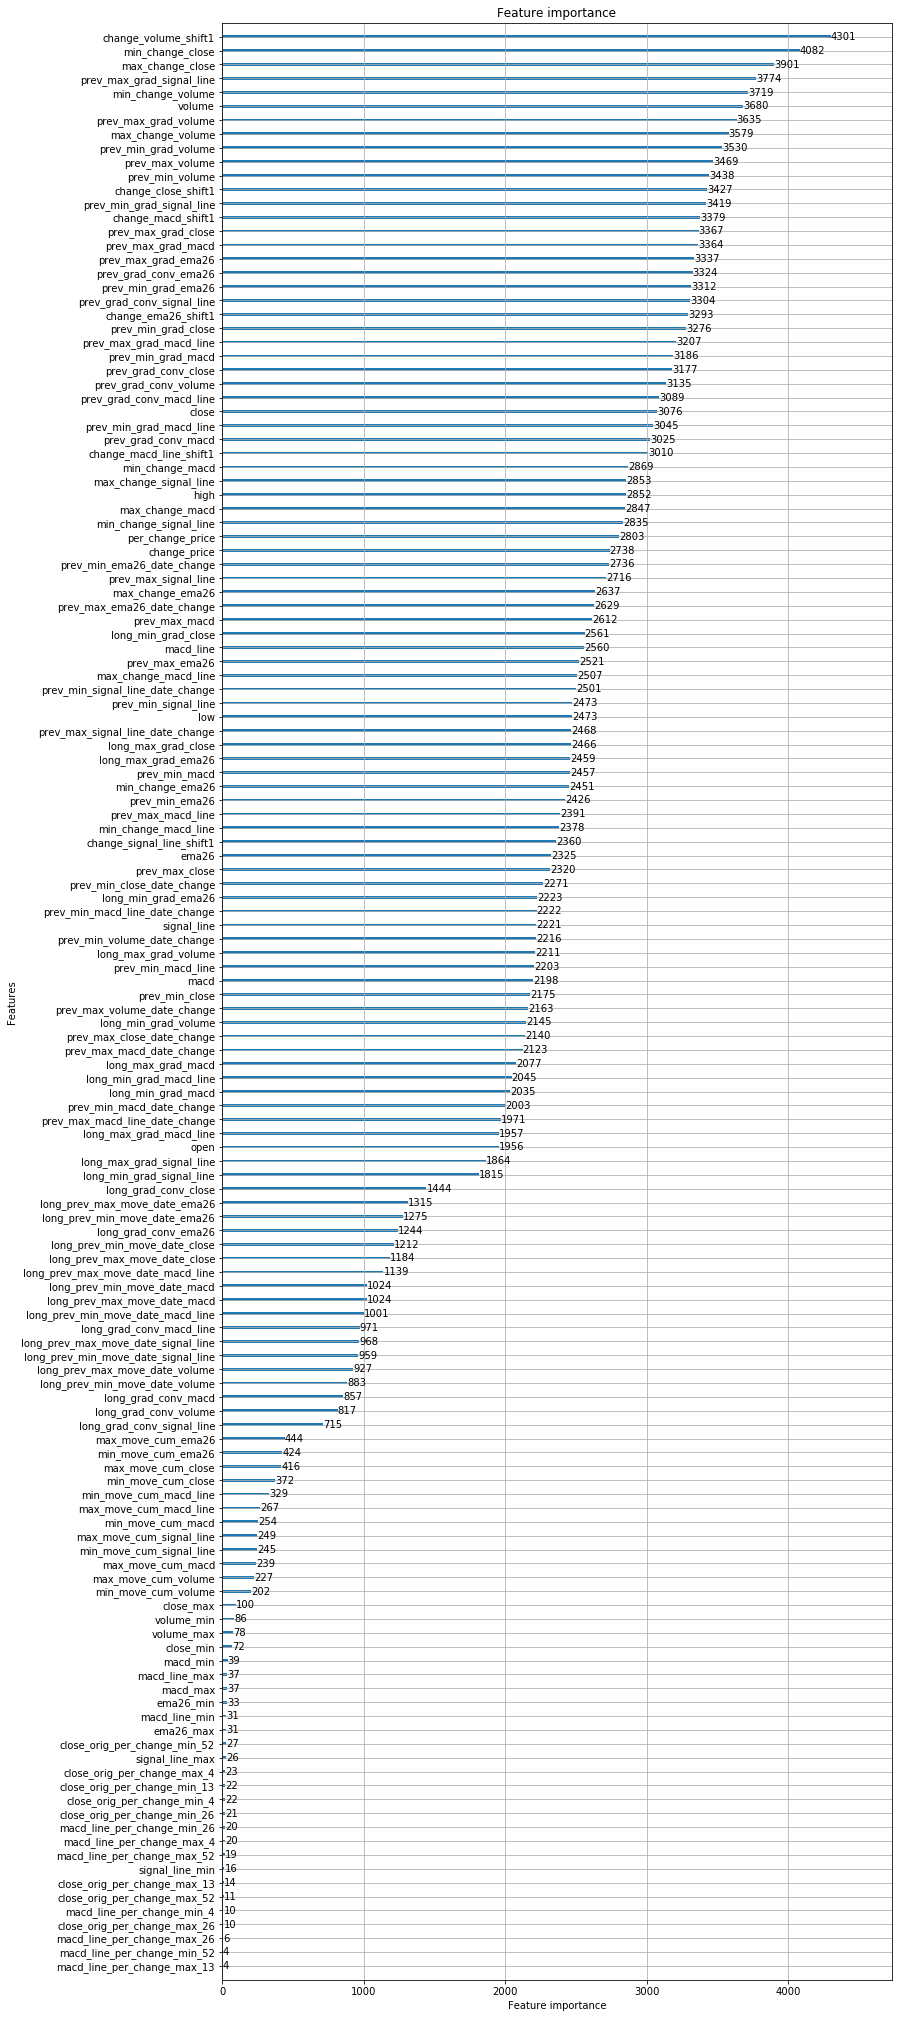

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
lgb.plot_importance(final_models,figsize=(12,36))

In [21]:
y_pred = final_models.predict(X_valid)
calc_tpr(y_pred,y_valid,['FINAL RF MODEL - VALIDATION SET'],y_valid.unique())    

,feature,tot_p,tot_n,tpr,tnr,ppv,npv,acc,auc,opt_text
0,[FINAL RF MODEL - VALIDATION SET],85329,8965,0.910038,0.101832,0.572478,0.461350,0.561913,0.505935,hold
1,[FINAL RF MODEL - VALIDATION SET],3071,91223,0.067331,0.974296,0.340931,0.841016,0.824729,0.520814,buy
2,[FINAL RF MODEL - VALIDATION SET],5894,88400,0.089085,0.947117,0.378860,0.741708,0.719028,0.518101,sell


In [22]:
y_pred = final_models.predict(X_train)
calc_tpr(y_pred,y_train,['FINAL RF MODEL - TRAINING SET'],y_train.unique())    

,feature,tot_p,tot_n,tpr,tnr,ppv,npv,acc,auc,opt_text
0,[FINAL RF MODEL - TRAINING SET],34526,152467,0.934466,0.998264,0.992440,0.984239,0.985753,0.966365,buy
1,[FINAL RF MODEL - TRAINING SET],112819,74174,0.995974,0.908562,0.934213,0.994257,0.958031,0.952268,hold
2,[FINAL RF MODEL - TRAINING SET],39648,147345,0.887039,0.998786,0.995637,0.965883,0.972191,0.942912,sell


# Exporting the model

In [23]:
#Import the modules
from sklearn.externals import joblib as jl

C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [24]:
#Export the model
jl.dump(final_models,path+r'\lgb_model.joblib')

['C:\\Users\\Robert\\Documents\\python_scripts\\stock_trading_ml_modelling\\historical_prices\\lgb_model.joblib']

In [25]:
#Export a list of the features for this model
file_object = open(path+r'\lgb_model_feature_list.txt','w')
feature_str = ''
for i in feature_cols:
    feature_str += '{},'.format(i)
feature_str = feature_str[:-1]
file_object.write(feature_str)
file_object.close()
feature_str

'open,close,high,low,volume,change_price,per_change_price,ema26,macd,signal_line,macd_line,close_orig_per_change_max_4,close_orig_per_change_max_13,close_orig_per_change_max_26,close_orig_per_change_max_52,close_orig_per_change_min_4,close_orig_per_change_min_13,close_orig_per_change_min_26,close_orig_per_change_min_52,macd_line_per_change_max_4,macd_line_per_change_max_13,macd_line_per_change_max_26,macd_line_per_change_max_52,macd_line_per_change_min_4,macd_line_per_change_min_13,macd_line_per_change_min_26,macd_line_per_change_min_52,change_close_shift1,close_max,close_min,prev_max_close,prev_min_close,prev_max_close_date_change,prev_min_close_date_change,max_change_close,min_change_close,prev_max_grad_close,prev_min_grad_close,prev_grad_conv_close,max_move_cum_close,min_move_cum_close,long_prev_max_move_date_close,long_prev_min_move_date_close,long_max_grad_close,long_min_grad_close,long_grad_conv_close,change_macd_shift1,macd_max,macd_min,prev_max_macd,prev_min_macd,prev_max_macd_